## Example: Thompson sampling and the Binary Bernoulli Bandit Problem
In this problem, we'll have three possible bandits (actions, $a_{1}, a_{2}$ and $a_{3}$) that we must choose from. Each of these alternatives has a probability $p_{a_{i}}$ of `success`, in which case the decision-making agent receives a reward of `r = 1`;  for a `failure`, the agent receives a reward of `r = 0`. The probabilities $p_{a_{i}}$ are known to the `world` but not to the decision-making agent. Thus, the agent must learn which action gives the best reward by sampling, i.e., interacting with the `world`.

### Learning objectives
In this example, the decision making agent will use [Thompson Sampling](https://arxiv.org/abs/1707.02038) and ϵ-greedy Thompson Sampling to learn the probability of success for each of the possible alternative actions. 

### Setup
In this example, we'll directly load some required packages, and a the `CHEME-5760-MABP-Example-CodeLib.jl` file that contains some helper functions that we'll use for the [Thompson Sampling](https://arxiv.org/abs/1707.02038) and ϵ-greedy Thompson Sampling.

In [1]:
import Pkg; Pkg.activate("."); Pkg.resolve(); Pkg.instantiate();

  Activating project at `~/Desktop/julia_work/CHEME-5760-Examples-F23`
  No Changes to `~/Desktop/julia_work/CHEME-5760-Examples-F23/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5760-Examples-F23/Manifest.toml`


In [2]:
# load reqd packages -
using Distributions
using Plots
using Colors
using StatsPlots
using PrettyTables
using DataFrames

# setup paths -
const _ROOT = pwd();
const _PATH_TO_FIGS = joinpath(_ROOT, "figs");

The `CHEME-5760-MABP-Example-CodeLib.jl` file contains several functions and types used in this example. We'll load these types and functions into the notebook using the `include(...)` function:

In [3]:
include("CHEME-5760-MABP-Example-CodeLib.jl");

### Initialize the world

The `world` for this example will be stored in the variable `world_d_dict::Dict{Int64, Bernoulli}` which holds the [Bernoulli distributions](https://en.wikipedia.org/wiki/Bernoulli_distribution) that describe the probability of `success` or `failure` for each action. 
* The probability of success (unknown to the decision-making agent) is stored in the `θ_array` variable. Our objective is to learn these probabilities by interacting with the world

In [4]:
# initialize the world -
world_d_dict = Dict{Int64, Bernoulli}();
K = 3; # number of bandits, i.e., number of actions
θ_array = [0.90, 0.60, 0.80]; # values taken from Russo et al Fig. 3.1
number_of_steps = 5000;
    
# hard code the parameters for the Bernoulli distributions, these are the 
# ground truth, but the agent doesn't know them (and they are not directly visible)
for k ∈ 1:K
    world_d_dict[k] = Bernoulli(θ_array[k]);
end

### Simulate the World
To simulate the response of the `world`, we build the `world(...)` function. The `world(...)` function takes an action `a` and a dictionary of probability models. It then selects the model corresponding to action `a` and samples it. If the value is `true`, the `world(...)` returns a reward of `r = 1`; otherwise, the agent receives `r = 0`.

In [5]:
# lets build a world function -
function world(action::Int64, dict::Dict{Int64, Bernoulli})::Int64
    
    # grab the distrubution from the dict -
    d = dict[action];
    
    # roll -
    value = rand(d);
    if (value == true)
        return 1;    
    end
    
    # default -
    return 0;
end;

Next, we construct an instance of the `ThompsonSamplingModel` type, which holds information about the problem. 
* The field `K` holds the number of bandits, i.e., the number of alternative actions available to the agent.
* The `α` and `β` fields are the parameter vectors the agent uses to learn the world. The `α` vector holds the number of `successes` for each action, while the `β` vector holds the number of failures.

Finally, we build the short-cut `world_function(a)`, called by the `sample(...)` function. The `world_function(a)` function takes an action, i.e., a choice of a `bandit` and returns the reward. The `sample(...)` function takes a `ThompsonSamplingModel` instance, the number of trials we want to do, and the world function and returns a dictionary that holds the parameter values learned as the number of stages increases.

In [6]:
# build Thompson sample object -
model = ThompsonSamplingModel()
model.K = K;
model.α = ones(K); # initialize to uniform values
model.β = ones(K); # initialize to uniform values

# build the world function 
world_function(a) = world(a, world_d_dict);

# Thompson sampling -
time_sample_results_dict_Ts = sample(model; 𝒯 = number_of_steps, world=world_function);

Similar to cell above, we construct the `EpsilonSamplingModel` instance which holds information about the ϵ-greedy sampling approach. The `EpsilonSamplingModel` type has one additional field, the `ϵ` field which controls the approximate fraction of `exploration` steps the algorithm takes; `exploration` steps are purely random.

The `sample(...)` function takes a `EpsilonSamplingModel` instance, the number of trials we want to do, and the world function and returns a dictionary that holds the parameter values learned as the number of stages increases.

In [7]:
# Build an epsilon sample object -
epsilon_model = EpsilonSamplingModel();
epsilon_model.K = K;
epsilon_model.α = ones(K); # initialize to uniform values
epsilon_model.β = ones(K); # initialize to uniform values
epsilon_model.ϵ = 0.20; # some fraction of the iterations, do a random step

# EPS-TS 
time_sample_results_dict_eps = sample(epsilon_model; 𝒯 = number_of_steps, world=world_function);

### Visualize
Let's visualize the agent’s progress as the number of rounds increases. First, specify the index of the round that you want to observe in the `T_index` variable:

In [15]:
T_index = number_of_steps;

Next, we build the `beta_array` for each sampling procedure using the `build_beta_array(...)` function is specified in the `CHEME-5760-MABP-Example-CodeLib.jl` file. 
* The `build_beta_array(...)` function takes the simulation dictionaries above and constructs [beta distribution](https://en.wikipedia.org/wiki/Beta_distribution), which describe the probability of `success` or each bandit, i.e., values for the $p_{a_{i}}$ that appear in the `Bernoulli` model used by the `world`

In [16]:
# build the array of beta distributions -
beta_array_Ts = build_beta_array(time_sample_results_dict_Ts[T_index]);
beta_array_eps = build_beta_array(time_sample_results_dict_eps[T_index]);

Finally, let's build a table to display our estimates of the `success` probability using the [PrettyTables.jl](https://github.com/ronisbr/PrettyTables.jl.git) package:

In [17]:
# initialize -
action_probability_array = Array{Any,2}(undef, K, 4);
for i ∈ 1:K
    
    action_probability_array[i,1] = i;
    action_probability_array[i,2] = θ_array[i];
    
    # get the d -
    d_Ts = beta_array_Ts[i];
    d_eps = beta_array_eps[i];
    
    # grab the parameters from distributions -
    # Thompson sampling -
    αᵢ,βᵢ = params(d_Ts);
    action_probability_array[i,3] = αᵢ/(αᵢ + βᵢ);
    
    # eps-TS -
    αᵢ,βᵢ = params(d_eps);
    action_probability_array[i,4] = αᵢ/(αᵢ + βᵢ);
end

# header -
action_table_header = (["Action aᵢ", "θᵢ", "θ̂ᵢ Ts", "θ̂ᵢ eps-Ts"]);

# display table -
pretty_table(action_probability_array; header = action_table_header)

┌───────────┬─────┬──────────┬───────────┐
│ Action aᵢ │  θᵢ │    θ̂ᵢ Ts │ θ̂ᵢ eps-Ts │
├───────────┼─────┼──────────┼───────────┤
│         1 │ 0.9 │ 0.906212 │  0.904119 │
│         2 │ 0.6 │ 0.619048 │  0.607955 │
│         3 │ 0.8 │      0.8 │  0.780899 │
└───────────┴─────┴──────────┴───────────┘


#### Plot: Thompson sampling results

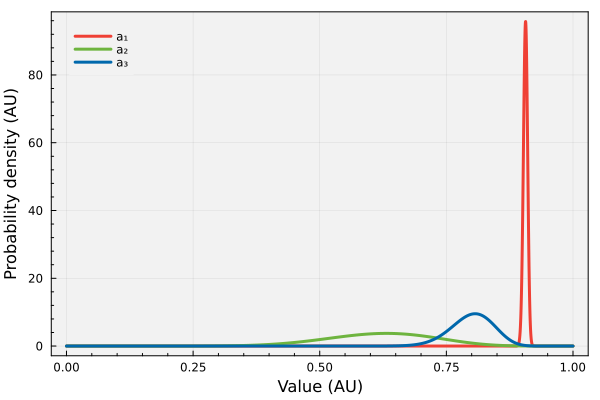

In [10]:
 # get the distributions for this time point -
plot(beta_array_Ts[1], legend=:topleft, label="a₁", lw=3, bg=colorant"#F2F2F2", 
    background_color_outside="white", framestyle = :box, fg_legend = :transparent, minorticks=0.05, 
    c=colorant"#EF4035")
plot!(beta_array_Ts[2], label="a₂", lw=3, c=colorant"#6EB43F")
plot!(beta_array_Ts[3], label="a₃", lw=3, c=colorant"#0068AC")

# setup labels -
xlabel!("Value (AU)", fontsize=18)
ylabel!("Probability density (AU)", fontsize=18)

# uncomment me to save -
#filename = "Fig-BBBP-Ts-T$(T_index).pdf"
#savefig(joinpath(_PATH_TO_FIGS, filename));

#### Plot: epsion-greedy Thompson sampling results

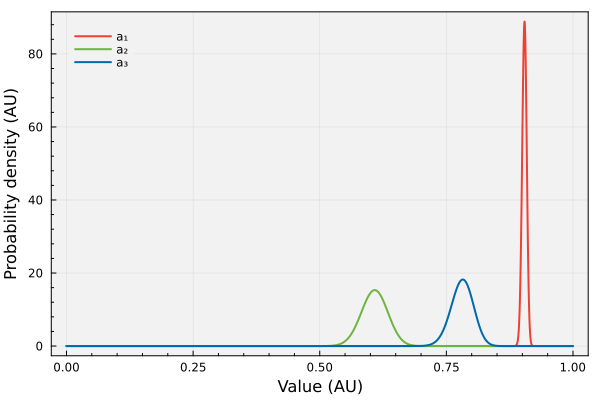

In [11]:
 # get the distributions for this time point -
plot(beta_array_eps[1], legend=:topleft, label="a₁", lw=2, bg=colorant"#F2F2F2", 
    background_color_outside="white", framestyle = :box, fg_legend = :transparent, minorticks=0.05, 
    c=colorant"#EF4035")
plot!(beta_array_eps[2], label="a₂", lw=2, c=colorant"#6EB43F")
plot!(beta_array_eps[3], label="a₃", lw=2, c=colorant"#0068AC")

# setup labels -
xlabel!("Value (AU)", fontsize=18)
ylabel!("Probability density (AU)", fontsize=18)

# uncomment me to save -
#filename = "Fig-BBBP-eps-20-T$(T_index).pdf"
#savefig(joinpath(_PATH_TO_FIGS, filename));

### Disclaimer and Risks
__This content is offered solely for training and  informational purposes__. No offer or solicitation to buy or sell securities or derivative products, or any investment or trading advice or strategy,  is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on your evaluation of your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.